# iFood case

This is my attempt at the iFood CRM case.  
Looking forward to hear from whomever is seeing this

* Leonardo Meireles Murtha Oliveira
* E-mail: l.meireles.murtha.oliveira@gmail.com
* [GitHub](https://github.com/leoMurtha)
* [LinkedIn](https://www.linkedin.com/in/leo-meireles-murtha/a)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shap
import random
import datetime
import numpy as np
import pandas as pd  
import seaborn as sns
from sklearn.svm import SVC
from math import floor, ceil
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, train_test_split, cross_val_score, StratifiedKFold

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.


In [3]:
# General setup
#plt.style.use('fivethirtyeight')
plt.style.use('fivethirtyeight')

plt.rcParams.update({'figure.figsize': (8, 4)})

# To be able to reproduce results
random.seed(42)

# Today variable, useful for calculating ages
today = datetime.datetime.now()

In [4]:
# Create an array with the colors you want to use
colors = ["#FCA082", "#FF3030"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

In [5]:
# MATPLOTLIB CONFIGS
plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# Helper Functions


In [6]:
def corr_plot(df, figsize=(11, 9), cmap='Blues'):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=False, linewidths=.5, cbar_kws={"shrink": .7}, annot=True, fmt=".1%")

    plt.xticks(rotation=60)
    plt.tight_layout()

def plot_cluster_var_comparison(df, exclude, cluster_var='Cluster'):
    if cluster_var not in exclude:
        exclude.append(cluster_var)

    columns = df.columns.difference(exclude)

    var_combinations = list(combinations(columns, 2))

    rows = ceil(len(var_combinations)/2)

    fig, axes = plt.subplots(rows, 2, figsize=(14, rows*5))

    axes = axes.ravel()

    axis_to_off = [i-1 for i in list(range(rows*2, len(var_combinations), -1))]

    for combination, ax in zip(var_combinations, axes):
        x_axis = combination[0]
        y_axis = combination[1]

        sns.scatterplot(data=df, x=x_axis, y=y_axis, hue=cluster_var,
                        legend='brief', ax=ax, s=70)

    for ax_i in axis_to_off:
        axes[ax_i].axis('off')

    plt.tight_layout()

def drop_highly_correlated(df, threshold=.95):
    init_shape = df.shape
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(
        upper[column] > threshold)]

    # Drop features
    df = df.drop(df[to_drop], axis=1)

    print(f'Dropping columns: {to_drop}')
    print(f'Initial df Shape: {init_shape}\nFinal df Shape: {df.shape}')

    return df

# Create a function for computing and plotting the ECDF with default parameters
def plot_ecdf(data, ax, xlabel='Data Values', ylabel='Percentage', color='#FF3030'):
    """ 
    Function to plot ecdf taking a column of data as input.
    """
    # ECF cacl
    xaxis = np.sort(data)
    yaxis = np.arange(1, len(data)+1)/len(data)

    ax.plot(xaxis, yaxis, linestyle='none', marker='.', color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.margins(0.02)

def plot_dist(df, columns, hist=True, ecdf=True, figsize=(8, 4), color='#FF3030'):
    """
    Plots histogram and ecdf plots for columns passed
    """
    for col in columns:
        f, ax = plt.subplots(1, 2, figsize=figsize)
        plt.suptitle(f'Histogram and ECDF for variable {col}')
        if hist:
            sns.distplot(df[col], ax=ax[0], color=color)
        if ecdf:
            plot_ecdf(df[col], ax=ax[1], xlabel=col, color=color)
        plt.tight_layout()
        plt.show()

def accpt_bar_plot(df, column, title='', xlabel='', figsize=(10, 5), ylim_offset=5):
    df_bar = (df.groupby(['accpt', column])[
              'ID'].nunique().to_frame('perc_customer')/df.shape[0])*100
    df_bar = df_bar.reset_index().sort_values(by='perc_customer', ascending=False)

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x=column, y='perc_customer', hue='accpt',
                     hue_order=["Didn't accept any campaign",
                                'Accepted at least one campaign'],
                     data=df_bar, alpha=1, saturation=1, edgecolor='k', linewidth=.7) #palette='Reds')
    
    
    # Add this loop to add the annotations
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate('%.1f' % height + '%', (x + width /
                                            1.8, y + height*1.01), ha='center')

    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    plt.legend(fontsize='medium', loc='best', title='')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('% of customers')
    plt.ylim(0, df_bar.perc_customer.max() + ylim_offset)
    plt.tight_layout()
    plt.savefig(f'./images/{column}_accpt.png', dpi=300)
    
    plt.show()

def campaign_success(df_, index):
    roi = round((df_[df_.Response == 1]['Z_Revenue'].sum() -
                 df_['Z_CostContact'].sum())/df_['Z_CostContact'].sum(), 2)
    success_rate = round(df_[df_.Response == 1].shape[0]/df_.shape[0], 2)
    customers = df_.ID.nunique()

    return pd.DataFrame([[customers, roi, success_rate]], 
                        columns=['Number of Customers', 'ROI', 'Success Rate'], index=[index])

# EDA

## To look for:

* Profiling the respondents:
    * Education 
    * Income
    * Age
    * Time as costumer
    * Buying behavior
    * RFM score of respondents
    

* As we don't know the kind of campaign that the marketing team realize, we will focus on understanding which consumers are more likely to accept any campaign. If we knew the scope of the campaign we could have done a more specific investigation, for example, if the next campaign would focus on alcoholic beverages, then having this knowledge we could search for patterns and discover customers which are more likely to buy alcoholic products when they have discounted prices or special deals.

In [7]:
# Reading data
df = pd.read_csv('data/ml_project1_data.csv')

* Creating age column from Year_Birth 

In [8]:
# Age column
df['Age'] = today.year - df['Year_Birth']

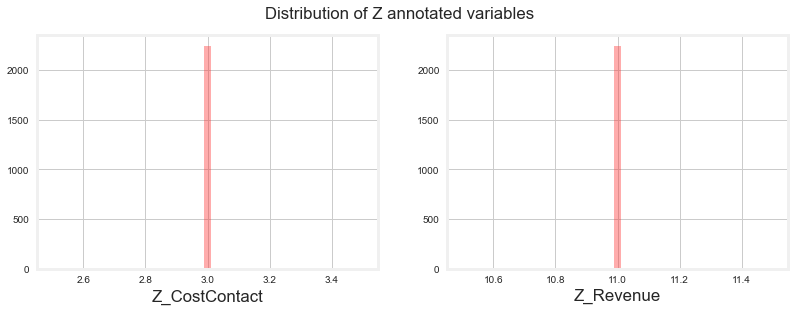

In [9]:
# Identifying out of scope variables
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plt.suptitle('Distribution of Z annotated variables')
sns.distplot(df['Z_CostContact'], ax=ax[0], kde=False, color='#FF3030')
sns.distplot(df['Z_Revenue'], ax=ax[1], kde=False, color='#FF3030')
plt.show()

## Z variables
* From the case .pdf file the Z variables are related to the campaign costs and success rates
* The campaign success rate and return of investment can be calculated through them

In [10]:
roi = round((df[df.Response==1]['Z_Revenue'].sum() - df['Z_CostContact'].sum())/df['Z_CostContact'].sum(), 2)
success_rate = round(df[df.Response==1].shape[0]/df.shape[0], 2)*100
print(f"Campaign success rate: {success_rate}%\nReturn on investment (ROI): {roi}%")

Campaign success rate: 15.0%
Return on investment (ROI): -0.45%


In [11]:
df.Response.value_counts()

0    1906
1     334
Name: Response, dtype: int64

In [12]:
# Non dummy variables like accepted campaign and response
non_dummy = ['Age', 'Income', 'Kidhome', 'Teenhome', 
              'Recency', 'MntWines', 'MntFruits',
              'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
              'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
              'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

Dropping columns: []
Initial df Shape: (2240, 28)
Final df Shape: (2240, 28)


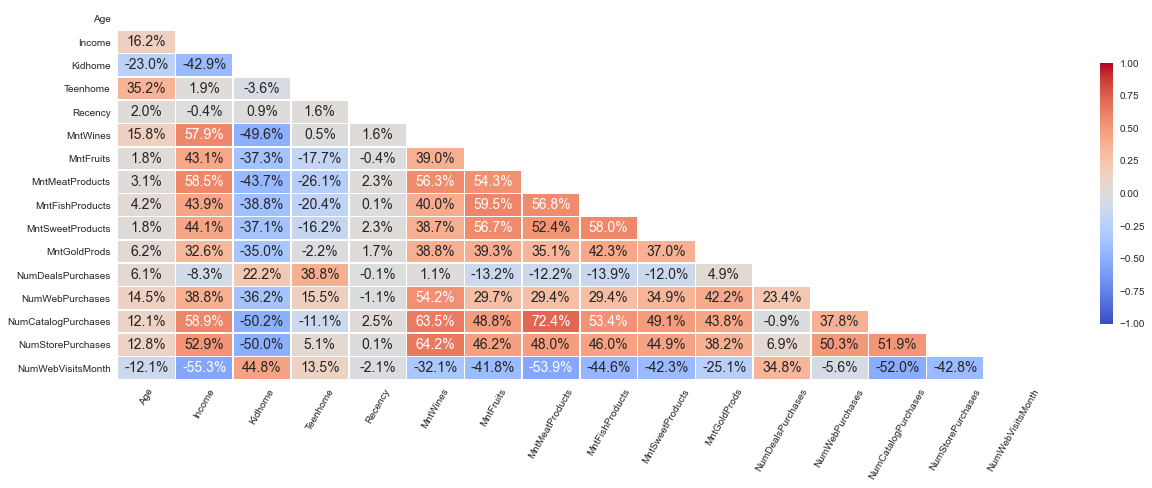

In [13]:
corr_plot(df[non_dummy], figsize=(18, 7), cmap='coolwarm')
# Checking for sanity if any correlation above .9 threshold
_ = drop_highly_correlated(df[df.columns.difference(['ID', 'Year_Birth'])], threshold=.9)

* There were no variables with correlation above .9

## Duplicates

In [14]:
# Checking for customers with multiple rows
df['ID'].value_counts().sort_values(ascending=False).to_frame('Customer Frequency').head()

,Customer Frequency
0,1
2061,1
6147,1
10245,1
10448,1


* The are no duplicates in this dataset

## Missing Values

In [15]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
Age                     0
dtype: int64

* Only the income column has missing values:
    * Values will be imputed using the mean of their group represented by: ['Education', 'Marital_Status', 'AgeGroup']
    * Age category is divided as:
        * 20-30
        * 30-50
        * 50 >

## Outlier detection

* Using histograms and ecdf plots to identify possible outliers in numerical columns
* Checking possible outlier in categorical columns like Marital Status, Education

### Numeric outlier

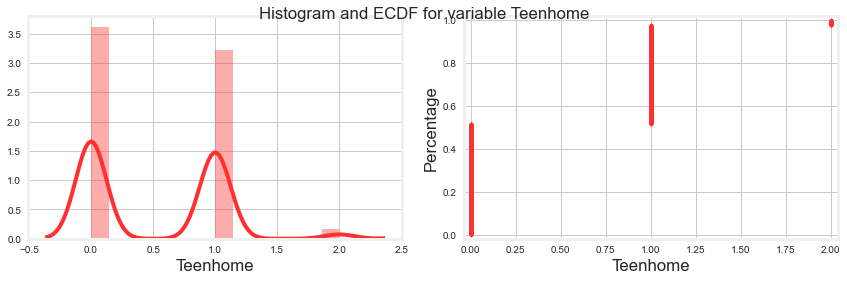

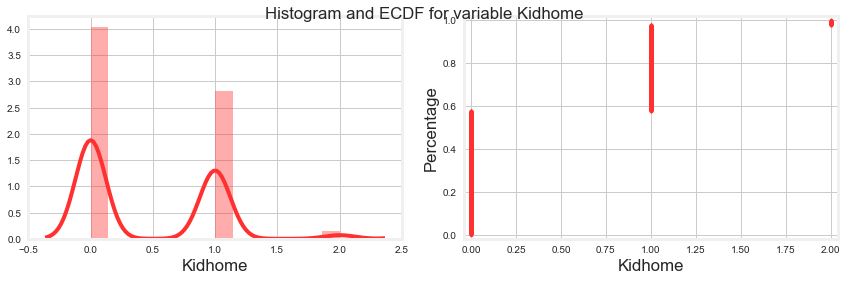

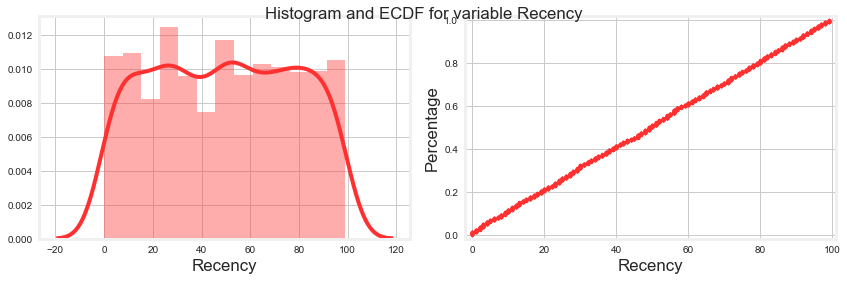

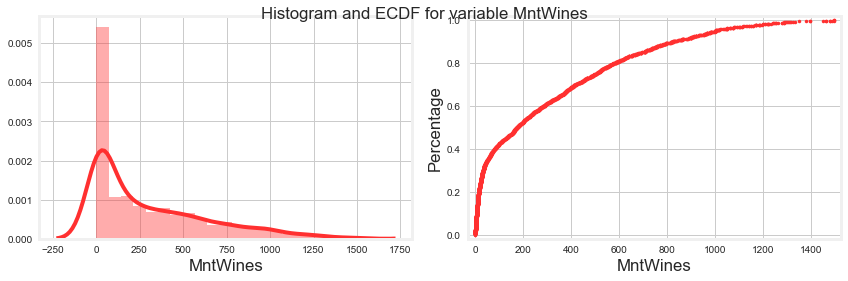

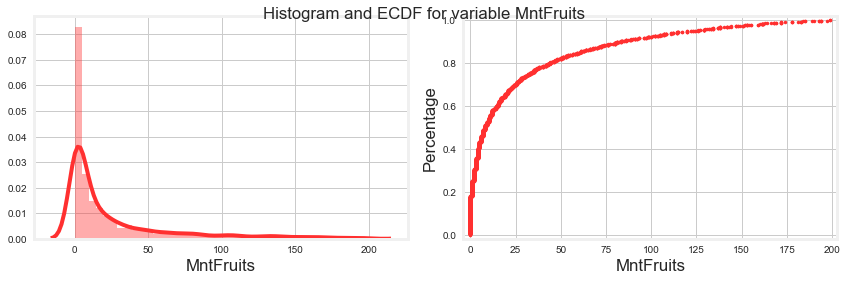

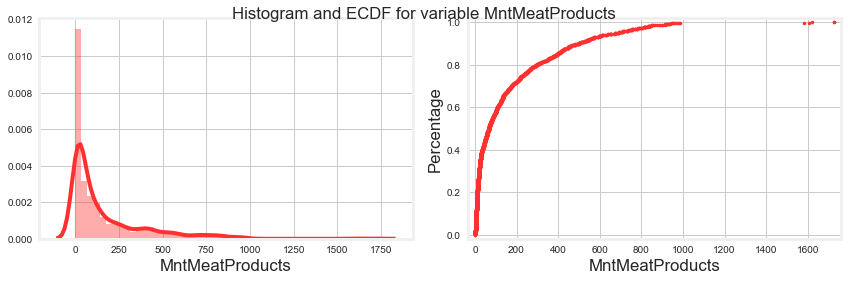

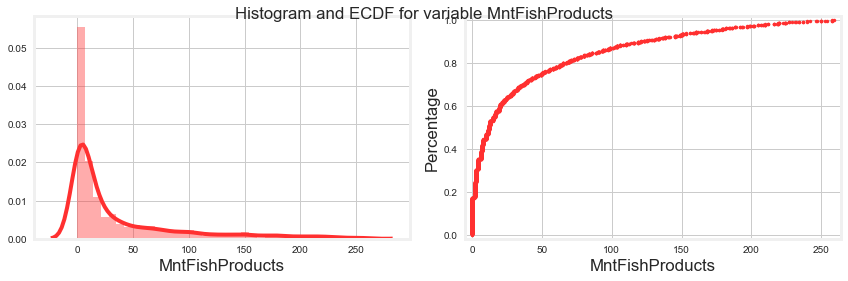

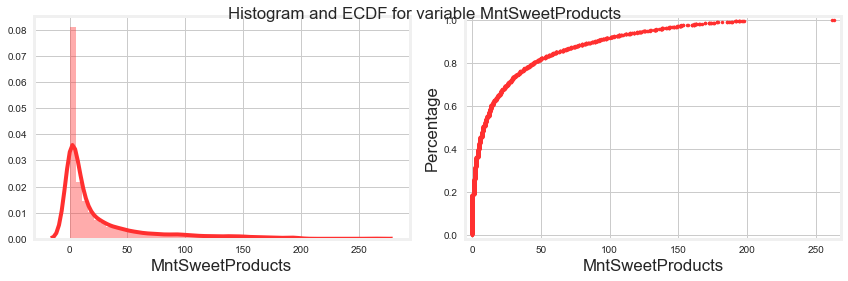

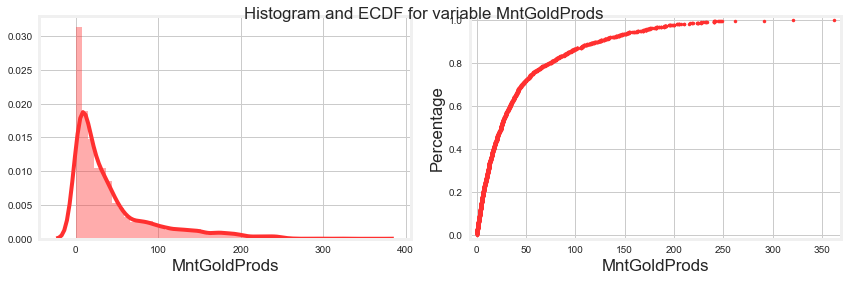

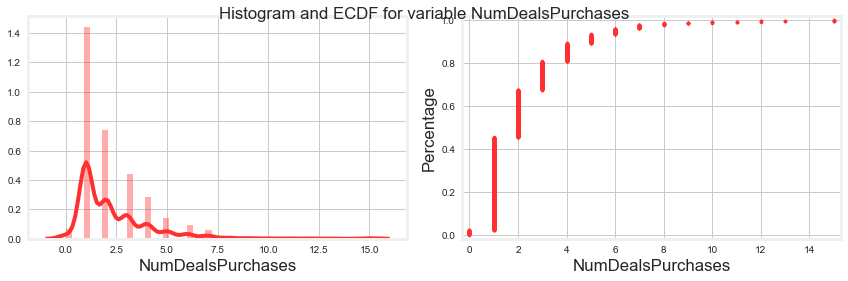

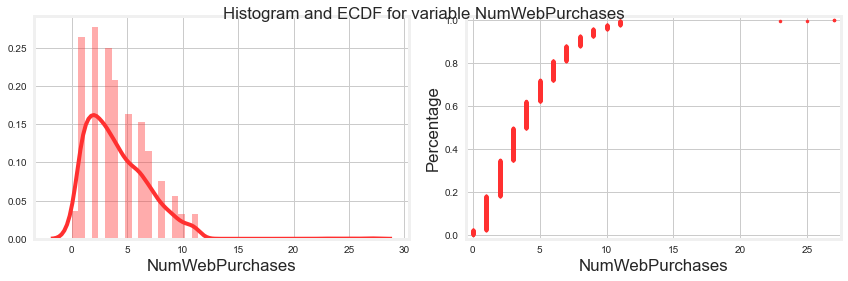

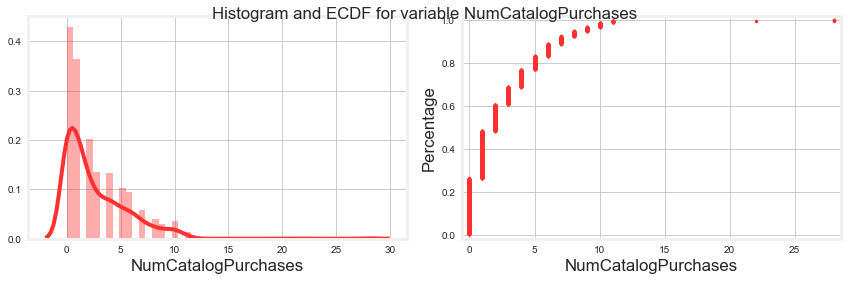

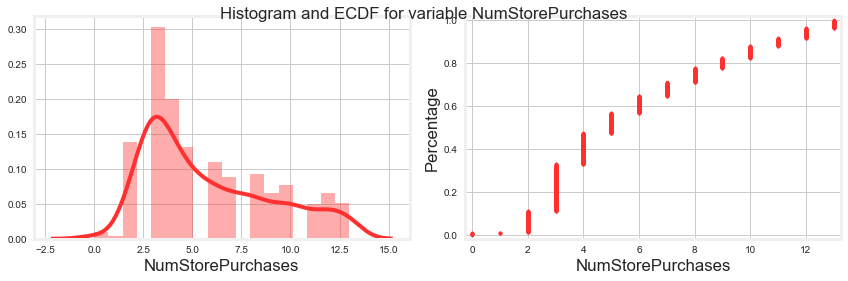

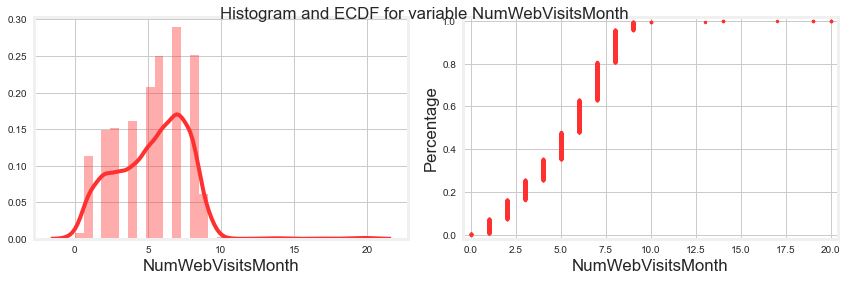

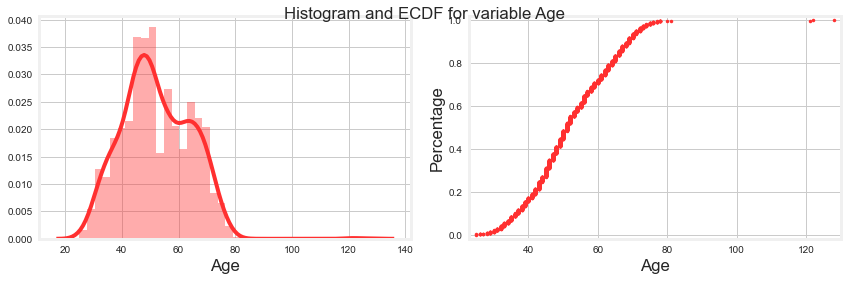

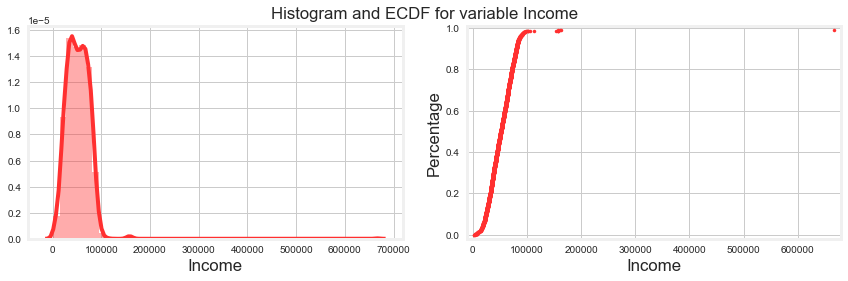

In [16]:
plot_dist(df, columns=['Teenhome', 'Kidhome', 'Recency', 'MntWines', 'MntFruits',
                       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
                       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'Income'], figsize=(12, 4))

* Seems like most of data is skewed this is a point of concern if we are going to use K-means, the data must not be skewed.
* Age and Income columns have outliers clear seen by its ECDF plots

* We will not remove customers with outlier columns instead we are going to clip it, all customers are eligible to receive any kind of deals. 
* Transformations:
    Age will be clipped with upper = 80 which is the maximum age before outliers occur
    The Income outlier which seems to be > 600000 will be replace with the median income of the population    

In [17]:
# Clipping age to 80, no need for lower bound because min age=24
df['Age'] = df['Age'].clip(upper=80)
# Replacing by income by the median
df.loc[df['Income'] > 6e5, 'Income'] = df.loc[df['Income'] < 6e5, 'Income'].median()

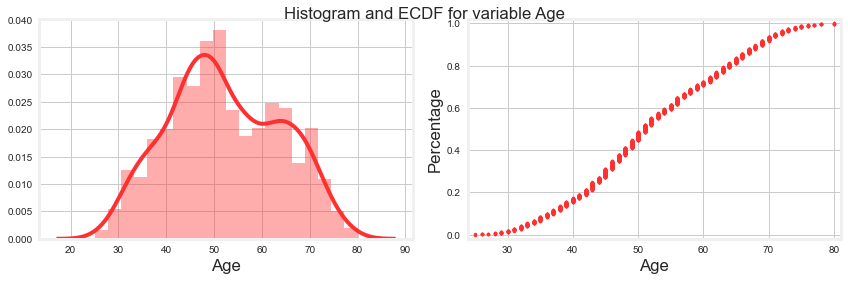

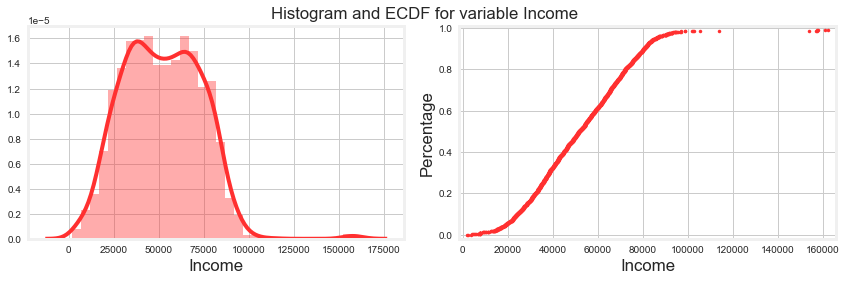

In [18]:
plot_dist(df, columns=['Age', 'Income'], figsize=(12, 4))

### Categorical outlier

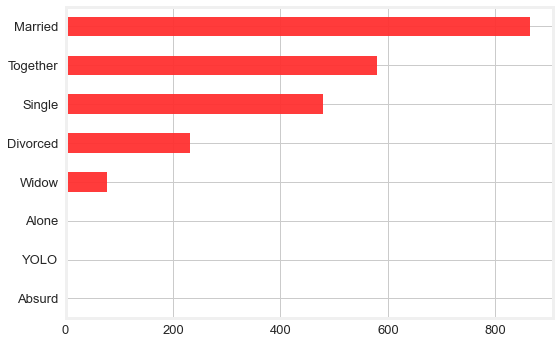

In [19]:
df['Marital_Status'].value_counts().sort_values().plot(kind = 'barh', color='#FF3030', alpha=.95, figsize=(8, 5), fontsize=13)
plt.tight_layout()
plt.show()

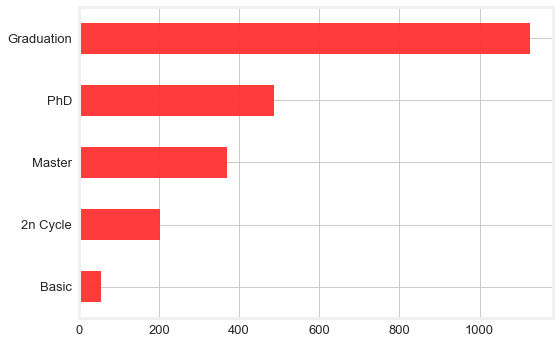

In [20]:
df['Education'].value_counts().sort_values().plot(kind = 'barh', color='#FF3030', alpha=.95, figsize=(8, 5), fontsize=13)
plt.tight_layout()
plt.show()

* Seems only the Marital Status columns has weird values such as Alone, Absurd, and Yolo.
* These values will be categorized as Other

In [21]:
# Other replace
df.loc[df['Marital_Status'].isin(['Alone',
       'Absurd', 'YOLO']), 'Marital_Status'] = 'Other'

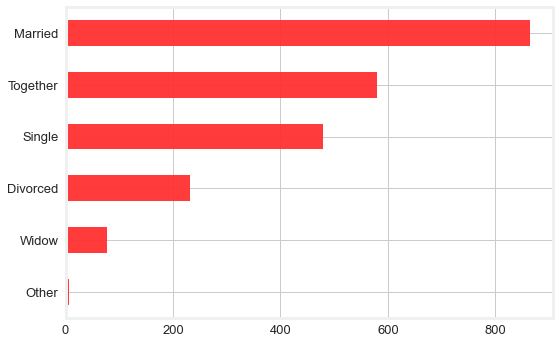

In [22]:
df['Marital_Status'].value_counts().sort_values().plot(kind = 'barh', color='#FF3030', alpha=.95, figsize=(8, 5), fontsize=13)
plt.tight_layout()
plt.show()

* Notice that Other marital status has a lower frequency in the customer dataset


## Campaign success rate

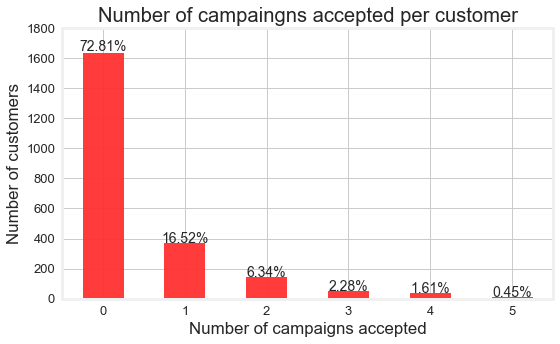

In [23]:
f, ax = plt.subplots(1, 1, )

freq_campaign = df[['Response', 'AcceptedCmp3', 'AcceptedCmp4',
                    'AcceptedCmp5', 'AcceptedCmp1',
                    'AcceptedCmp2']].sum(axis=1). \
    value_counts().sort_values(ascending=False).to_frame('freq')

ax = freq_campaign.freq.plot(kind='bar', color='#FF3030', 
                        alpha=.95, fontsize=13, 
                        figsize=(8, 5))

plt.title('Number of campaingns accepted per customer')
plt.xlabel('Number of campaigns accepted')
plt.ylabel('Number of customers')

# Add this loop to add the annotations
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    perc = p.get_height()/df.shape[0]
    x, y = p.get_xy()
    ax.annotate(f'{perc:.02%}', (x + width/2, y + height*1.01), ha='center')
    

plt.xticks(rotation=0)
plt.ylim(0, 1800)

plt.tight_layout()
plt.show()

* From the plot above we can notice that:
 * ~73% of the customers didn't accept any campaign
 * ~27% of the customers accepted at least one campaign
 * And there is a few number of customers which accepted all of the campaigns, 10 customers to be exact

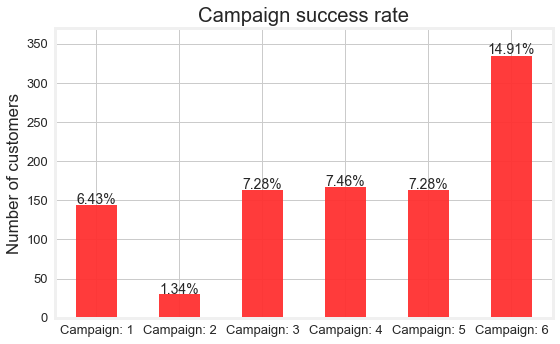

In [24]:
df_cmp = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum()
df_cmp.index = [f'Campaign: {i}' for i in range(1, 7)]

ax = df_cmp.plot(kind='bar', color='#FF3030', 
                        alpha=.95, fontsize=13, 
                        figsize=(8, 5))

plt.title('Campaign success rate')
plt.ylabel('Number of customers')

# Add this loop to add the annotations
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    perc = p.get_height()/df.shape[0]
    x, y = p.get_xy()
    ax.annotate(f'{perc:.02%}', (x + width/2, y + height*1.01), ha='center')
    
plt.xticks(rotation=0)
plt.ylim(0, 370)
plt.tight_layout()
plt.show()

* From the plot above:
    * The last campaign was the most successful in terms of customer adhesion, doubling last campaigns success rate.
    * Campaign 2 was the worst one with 1.34% customer adhesion

## Profiling respondents

* In this section an analysis will be made to better understand the costumers who positively responded to the campaigns

In [25]:
df['accpt'] = "Didn't accept any campaign"

accpt_mask = df[['Response', 'AcceptedCmp3', 
                 'AcceptedCmp4', 'AcceptedCmp5', 
                 'AcceptedCmp1', 'AcceptedCmp2']].sum(axis=1) > 0

df.loc[accpt_mask, 'accpt'] = 'Accepted at least one campaign'

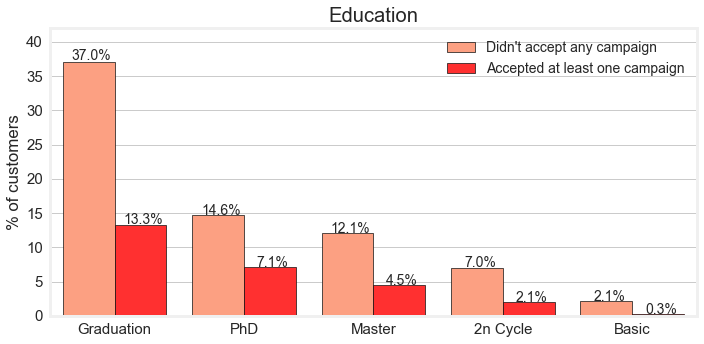

In [26]:
accpt_bar_plot(df, 'Education', title='Education')

In [27]:
# f, ax = plt.subplots(2, 2, figsize=(16, 8), constrained_layout=True)
# plt.grid(False)
# accpt_bar_plot(df, 'Education', ax=ax[0][1])
# accpt_bar_plot(df, 'Marital_Status', ylim_offset=5, ax=ax[0][0])

# accpt_bar_plot(df, 'AgeGroup', xlabel='Age Range', ylim_offset=10, ax=ax[1][0])
# accpt_bar_plot(df, 'Kidhome', xlabel='Number of kids at home', ylim_offset=5, ax=ax[1][1])

# plt.savefig('images/com_profile.png', dpi=300, bbox_inches='tight')
# #plt.tight_layout()

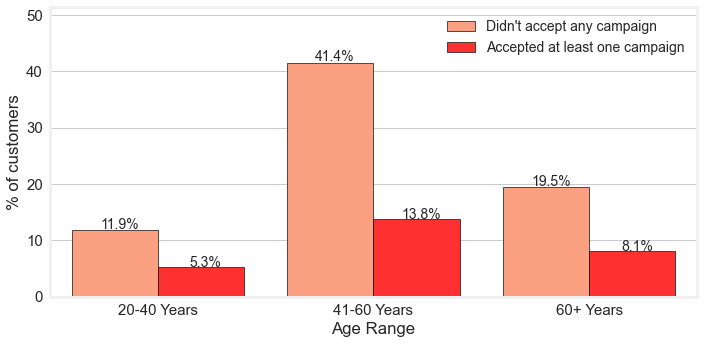

In [28]:
# Creating age groups
labels = ['20-40 Years', '41-60 Years', '60+ Years']
bins = [20, 40, 60, 100]
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels,)
accpt_bar_plot(df, 'AgeGroup', xlabel='Age Range', ylim_offset=10)

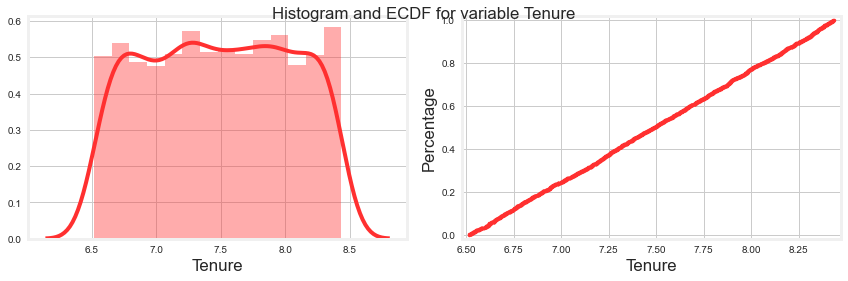

In [29]:
# Tenure, i.e, time as consumer
df['Tenure'] = (today - pd.to_datetime(df.Dt_Customer)).dt.days/365
plot_dist(df, columns=['Tenure'], figsize=(12, 4))

* The time as costumer (tenure) is well spread across customers


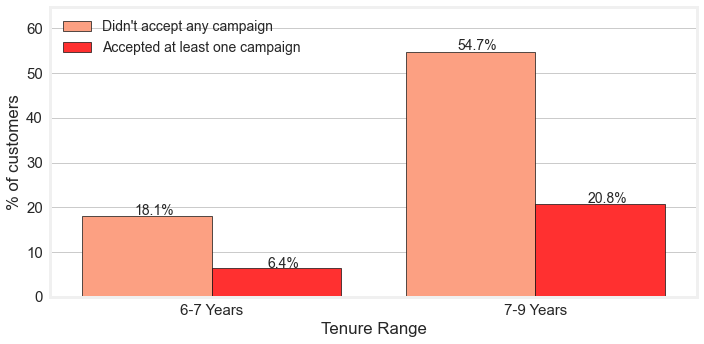

In [30]:
# Creating age groups
labels = ['6-7 Years', '7-9 Years']
bins = [6, 7, 9]
df['TenureGroup'] = pd.cut(df['Tenure'], bins=bins, labels=labels,)
accpt_bar_plot(df, 'TenureGroup', xlabel='Tenure Range', ylim_offset=10)

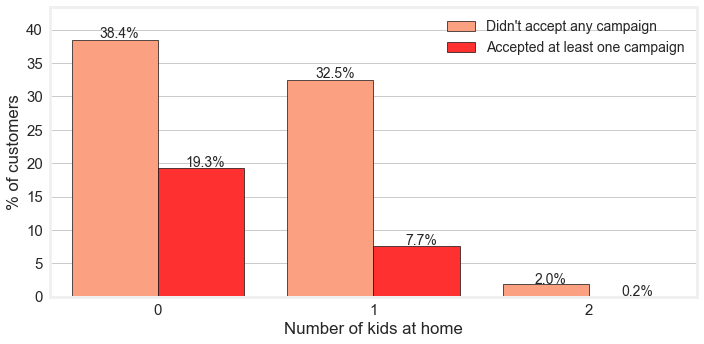

In [31]:
accpt_bar_plot(df, 'Kidhome', xlabel='Number of kids at home', ylim_offset=5)

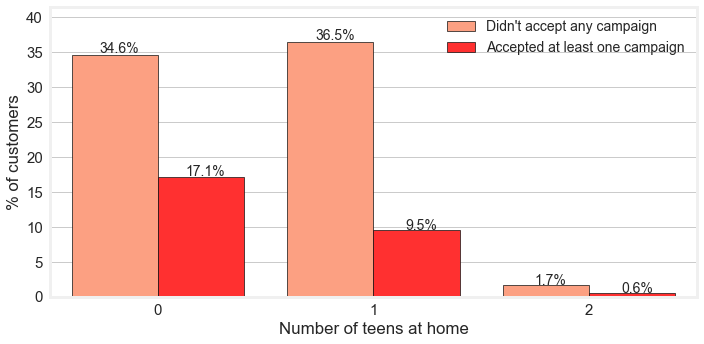

In [32]:
accpt_bar_plot(df, 'Teenhome', xlabel='Number of teens at home', ylim_offset=5)

In [33]:
# Number of children at home
df['Number_Children'] = df['Kidhome'] + df['Teenhome']

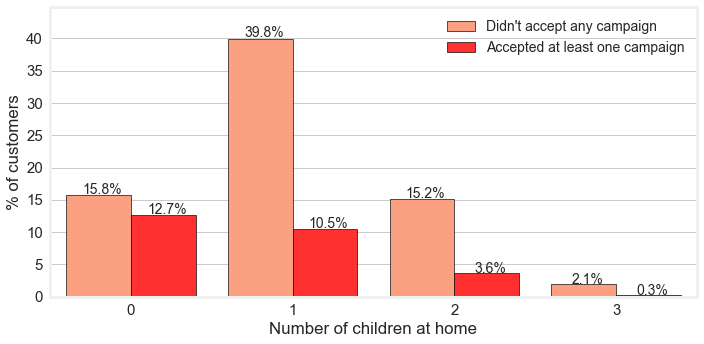

In [34]:
accpt_bar_plot(df, 'Number_Children', xlabel='Number of children at home', ylim_offset=5)

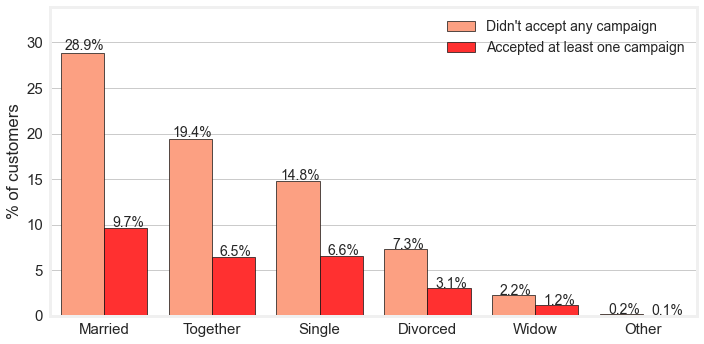

In [35]:
accpt_bar_plot(df, 'Marital_Status', ylim_offset=5)

In [36]:
# def discrete_to_cat(df, columns):
#     df_cat = df.set_index('ID')[columns + ['Response']].copy()
#     new_cols = {col: col.replace(r'Mnt', '').replace('Num', '') for col in columns}
#     df_cat = df_cat.rename(columns=new_cols)
#     new_cols = list(new_cols.values())
    
#     df_cat[new_cols] = df_cat[new_cols].apply(lambda x: (x > 0).astype(int), axis=1)
    
#     return df_cat

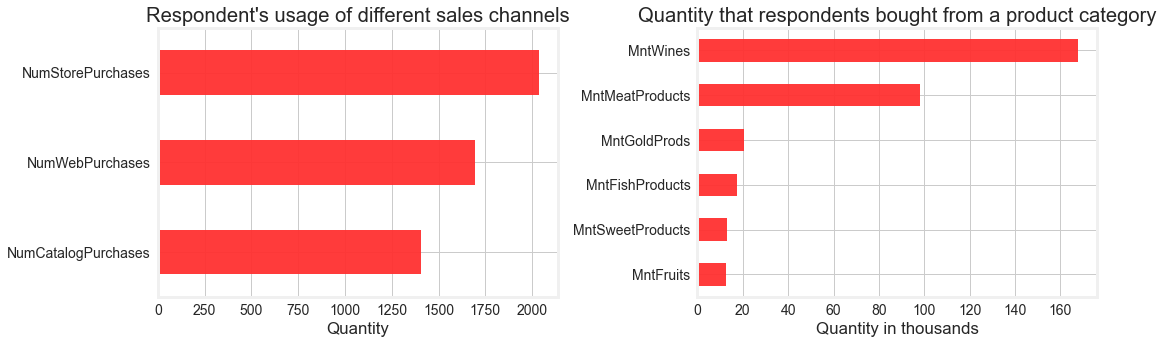

In [37]:
f, ax = plt.subplots(1, 2, figsize=(16, 5))

(df[df.Response == 1][['MntWines', 'MntFruits', 
                     'MntMeatProducts', 'MntFishProducts',
                     'MntSweetProducts', 'MntGoldProds']]\
                    .sum()/1e3).sort_values().plot(kind='barh', 
                                              color='#ff3030', 
                                              alpha=.95, 
                                              ax=ax[1])
ax[1].xaxis.set_tick_params(labelsize=14)
ax[1].yaxis.set_tick_params(labelsize=14)
ax[1].set_xlabel('Quantity in thousands')
ax[1].set_title('Quantity that respondents bought from a product category')

# Second plot

df[df.Response == 1][['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']]\
                .sum().sort_values().plot(kind='barh', 
                                          color='#ff3030', 
                                          alpha=.95, 
                                          ax=ax[0])
ax[0].xaxis.set_tick_params(labelsize=14)
ax[0].yaxis.set_tick_params(labelsize=14)
ax[0].set_xlabel('Quantity')
ax[0].set_title("Respondent's usage of different sales channels")
plt.tight_layout()
plt.savefig('images/buying_behavior.png', dpi=300, bbox_inches='tight')
plt.show()

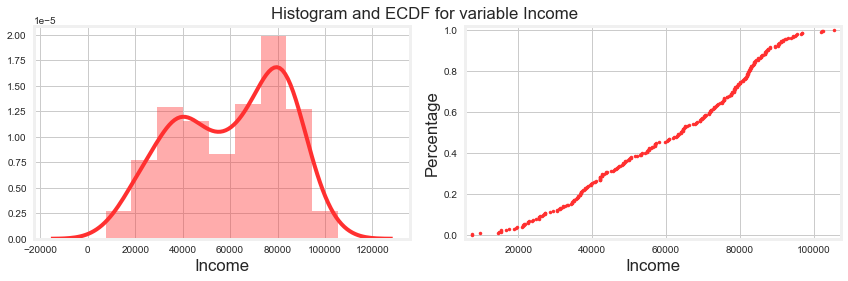

In [38]:
plot_dist(df[df.Response==1], columns=['Income'], figsize=(12, 4))

In [39]:
df[df.Response==1]['Income'].agg([min, max, 'mean', 'median'])

min         7500.000000
max       105471.000000
mean       60209.675676
median     64090.000000
Name: Income, dtype: float64

In [40]:
# Adding var to non dummy variables
non_dummy.append('Tenure')

In [41]:
variation_df = df.groupby('accpt')[non_dummy].mean().T
variation_df.columns = ['mean_accpt', 'mean_non_accpt']

In [42]:
variation_df['mean_variation'] = ((variation_df['mean_accpt'] - variation_df['mean_non_accpt']) /
                variation_df['mean_non_accpt']).round(2).to_frame('Variation_Accpt_NonAccpt')\

variation_df = variation_df.drop(['Kidhome', 'Teenhome', 'Age', 'Recency', 'Tenure', 'NumWebVisitsMonth'])

In [43]:
variation_df

,mean_accpt,mean_non_accpt,mean_variation
Income,61754.566942,48294.911856,0.28
MntWines,537.558292,216.703250,1.48
MntFruits,35.845649,22.738811,0.58
MntMeatProducts,277.275862,125.755365,1.20
MntFishProducts,52.131363,32.071735,0.63
MntSweetProducts,38.174056,22.914163,0.67
MntGoldProds,60.348112,37.925812,0.59
NumDealsPurchases,2.218391,2.364807,-0.06
NumWebPurchases,5.062397,3.719804,0.36
NumCatalogPurchases,4.128079,2.114654,0.95


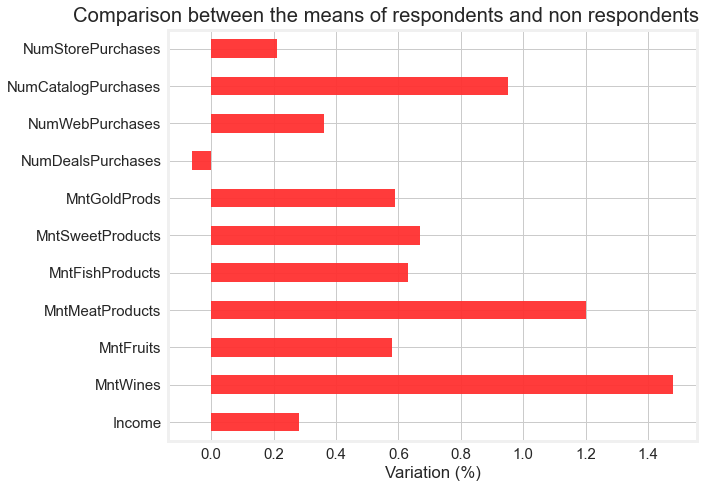

In [44]:
ax = variation_df['mean_variation'].plot(kind='barh', color="#FF3030", alpha=.95, figsize=(10, 7), legend=None)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
plt.title('Comparison between the means of respondents and non respondents', loc='left', x=-0.18049, y=1.005)
plt.xlabel('Variation (%)')
plt.tight_layout()
plt.savefig('images/comparison_of_means.png', dpi=300, bbox_inches='tight')
plt.show()

### Insights over respondents:

* Looking over the education of respondents, most of them have higher education, is the campaign somehow discriminating?
* However most of the customer in the dataset have higher education, why is that?
* Education: majority of them have higher education 
* Income: average income of 60000
* Age: the biggest age group with respondent is 41-60 Years
* Time as costumer: majority of them have been a customer for at least 7 years 
* People at home: most of the respondents don't have children or teenagers at home
* Marital Status: majority is either married or living together
* Buying behavior: biggest sale channel is the physical one and the most bought product is wine
* RFM score of respondents: expected to be really high

# RFM Segmentation

* Recency, frequency, monetary, and tenure segmentation of customers
* Recency: days since last purchase
* Frequency: how many times has the customer used any of the sales channels
* Monetary: In this case we don't have the price spent so we are going to assume a price unit for every kind of product except for gold products which will have a price unit of 2

In [45]:
# Gold products have higher "monetary" value
df['MntGoldProds'] *= 2

In [46]:
df['Monetary'] = df[['MntWines', 'MntFruits', 
                    'MntMeatProducts', 'MntFishProducts', 
                    'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

In [47]:
# +1 because if customer is in dataset he must have bought something at least one time
df['Frequency'] = 1 + df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

## Checking for outliers

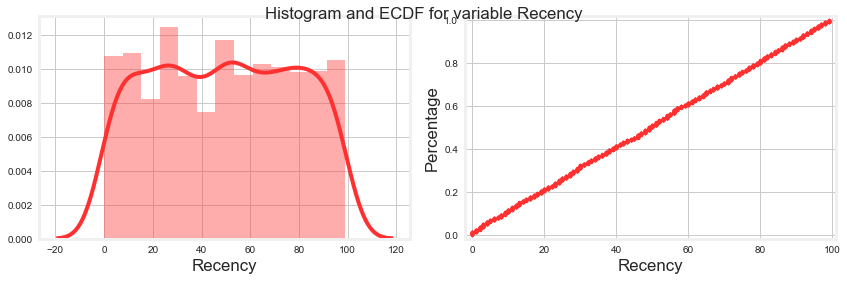

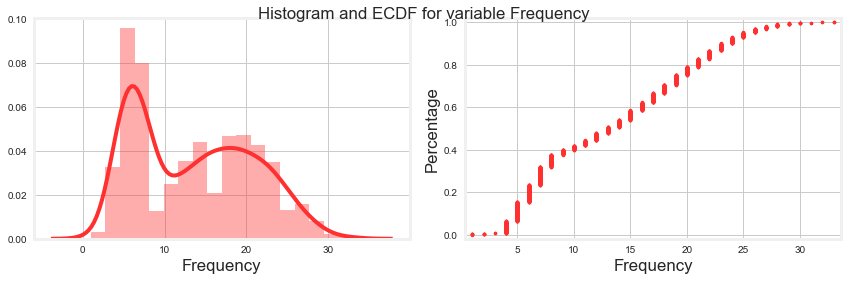

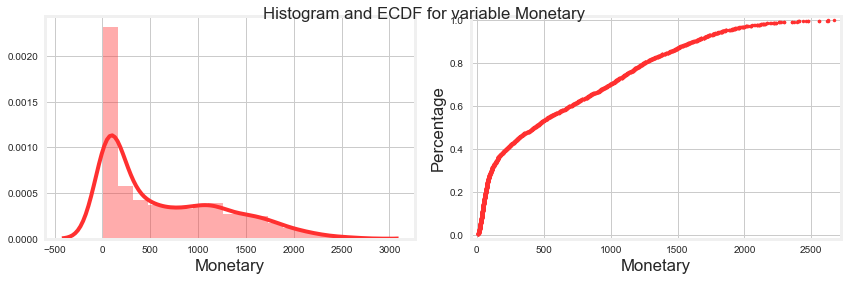

In [48]:
plot_dist(df, columns=['Recency', 'Frequency', 'Monetary'], figsize=(12, 4))

* No apparent outliers in the RFMT variables, so we continue with the segmentation

## Quantiles cutting
* RFM variables will cut in quartiles
* 1 - Low Score
* 4 - High Score

In [49]:
# Assigning scores to the variables
df['r_score'] = pd.qcut(df['Recency'], q=4, labels=range(4, 0, -1))
df['f_score'] = pd.qcut(df['Frequency'], q=4, labels=range(1, 5))
df['m_score'] = pd.qcut(df['Monetary'], q=4, labels=range(1, 5))

## Analyzing acceptance over RFM variables

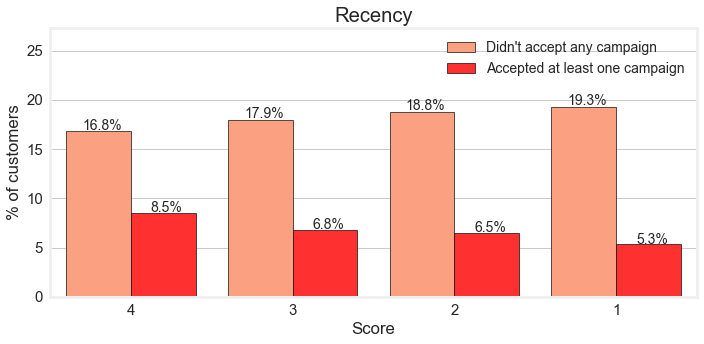

In [50]:
accpt_bar_plot(df, 'r_score', title='Recency', xlabel='Score', ylim_offset=8)

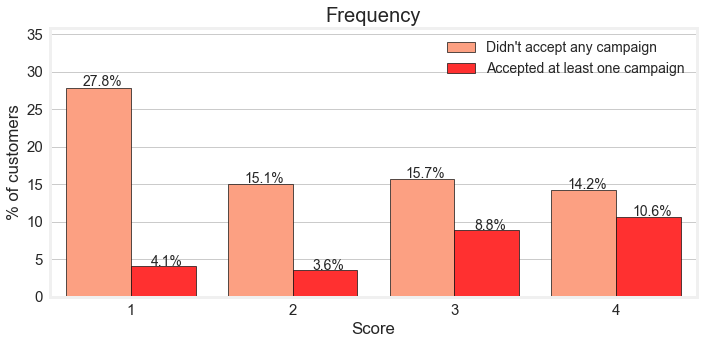

In [51]:
accpt_bar_plot(df, 'f_score', title='Frequency', xlabel='Score', ylim_offset=8)

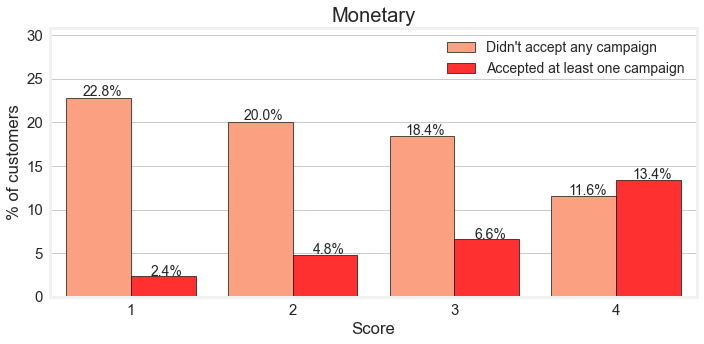

In [52]:
accpt_bar_plot(df, 'm_score', title='Monetary', xlabel='Score', ylim_offset=8)

* We can notice that higher scores tend to have higher acceptance. 
* Knowing this we could formulate a simple approach for the marketing team which uses these **RFM** scores.

## Segmentation using scores
* Usually at this stage we would define segments based on business knowledge and the sum of the RFM scores.
* A different approach using K-Means to find clusters will be followed.

## K-Means Clustering

* The data will be preprocessed so K-Means have a better chance to converge to an optimal solution.
* The number of clusters will be found using the elbow-method with the silhouette score as the metric of evaluation.
* An analysis of the clusters and how they behave will be done later on

### K-Means assumption and data preprocessing

* Data will be processed to satisfy K-Means assumptions which are:
    * Symmetric distributions of variables (not skewed)
    * Variables with same average values. This makes ensures that each metric receives an equal weight in the K-Means calculation.
    * Variables with same variance, this also ensures equal importance in the clustering calculation.

In [53]:
rfm_columns = ['Recency', 'Frequency', 'Monetary']
df_rfm = df.set_index('ID')[rfm_columns].copy()

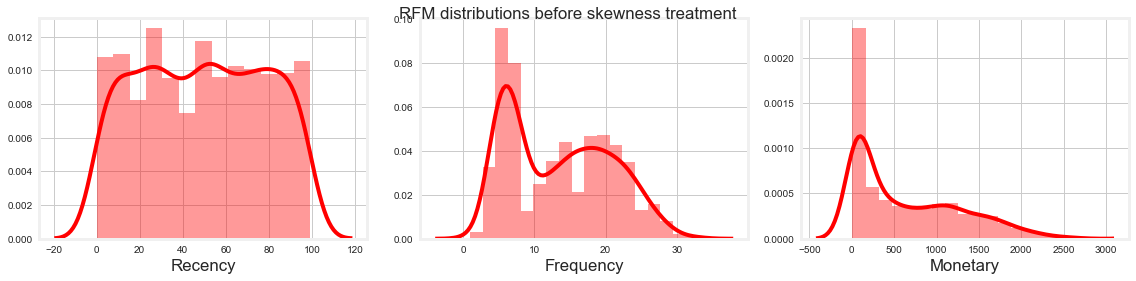

In [54]:
# Before log transform plot
f, ax = plt.subplots(1, len(rfm_columns), figsize=(16, 4))

plt.suptitle('RFM distributions before skewness treatment')
for col, i in zip(rfm_columns, range(len(rfm_columns))):
    sns.distplot(df_rfm[col], ax=ax[i], color='red')
    
plt.tight_layout()
plt.show()

* Frequency and Monetary variables distributions are skewed, this will be treated

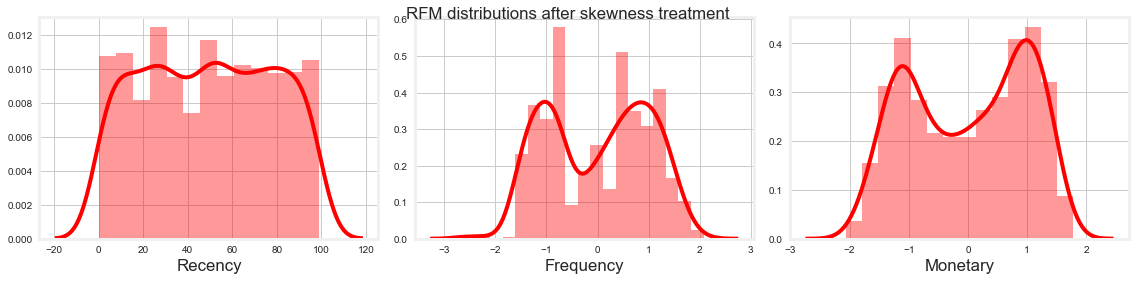

In [55]:
# Skewennes treatment is to take the log (Values must be positive)
# Applying log + 1 (because of zeros), to treat skewness
df_rfm[['Frequency', 'Monetary']] = PowerTransformer(method='yeo-johnson').fit_transform(df_rfm[['Frequency', 'Monetary']])

#df_rfm[['Frequency', 'Monetary']].transform(lambda v: np.log(v))

# After log transform plot
f, ax = plt.subplots(1, len(rfm_columns), figsize=(16, 4))

plt.suptitle('RFM distributions after skewness treatment')
for col, i in zip(rfm_columns, range(len(rfm_columns))):
    sns.distplot(df_rfm[col], ax=ax[i], color='red')
    
plt.tight_layout()
plt.show()

In [56]:
df_rfm.skew()

Recency     -0.001987
Frequency   -0.080634
Monetary    -0.125805
dtype: float64

In [57]:
# Scaling data so mean and variance of variables are the same
# Use StandardScaler
df_rfm.describe().round(3)

,Recency,Frequency,Monetary
count,2240.000,2240.000,2240.000
mean,49.109,-0.000,0.000
std,28.962,1.000,1.000
min,0.000,-2.597,-2.068
25%,24.000,-0.872,-0.974
50%,49.000,0.096,0.113
75%,74.000,0.820,0.917
max,99.000,2.076,1.781


In [58]:
# Scaling the variables so they have same avg and std values, only Recency because the other ones were powertransformed
df_rfm[['Recency']] = StandardScaler().fit_transform(df_rfm[['Recency']])

In [59]:
# Describe after scaling
# Variables have the same avg and std values
df_rfm.describe().round(5)

,Recency,Frequency,Monetary
count,2240.00000,2240.00000,2240.00000
mean,0.00000,-0.00000,0.00000
std,1.00022,1.00022,1.00022
min,-1.69600,-2.59747,-2.06774
25%,-0.86716,-0.87247,-0.97418
50%,-0.00378,0.09627,0.11318
75%,0.85960,0.81962,0.91660
max,1.72298,2.07618,1.78075


### Finding K

* Using elbow-method to find the K number of clusters

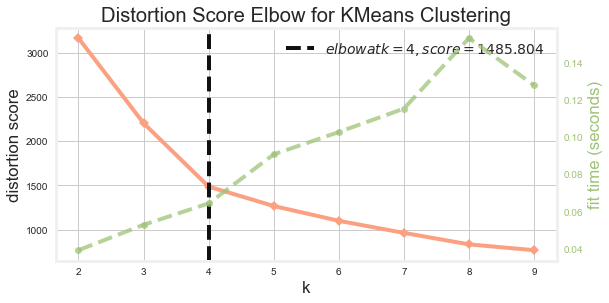

In [60]:
# Instantiate the clustering model and visualizer
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(2, 10))

visualizer.fit(df_rfm[rfm_columns].values)        # Fit the data to the visualizer
ax = visualizer.show()        # Finalize and render the figure

* Using the elbow method the best K segmentations is 4

In [61]:
kmeans = KMeans(random_state=42, n_clusters=int(visualizer.elbow_value_))

In [62]:
df_rfm_copy = df_rfm.copy()

In [80]:
df_rfm = df_rfm_copy.copy()
df_rfm['Cluster'] = kmeans.fit_predict(df_rfm[rfm_columns].values)
df_rfm['Cluster'] = df_rfm['Cluster'].astype(int)
df_rfm = df_rfm.reset_index()

# Assigning labels to original dataframe
df['Cluster'] = df_rfm['Cluster']

In [81]:
# Silhouette score to see how well K-Means performed
s_score = silhouette_score(df_rfm[rfm_columns].values, df_rfm['Cluster'].values, random_state=42)
print(f'Silhoutte Score: {s_score}')

Silhoutte Score: 0.4129315830699202


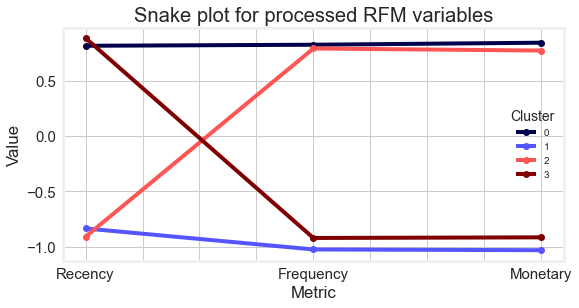

In [82]:
# Melt the normalized dataset and reset the index
df_melt = pd.melt(
                df_rfm, 
# Assign ID and Cluster as ID variables                  
                id_vars=['ID', 'Cluster'],

# Assign RFMT values as value variables
                value_vars=['Recency', 'Frequency', 'Monetary'], 
# Name the variable and value
                var_name='Metric', value_name='Value'
                )

df_piv = df_melt.pivot_table("Value", "Metric", "Cluster")
df_piv = df_piv.reindex(['Recency', 'Frequency', 'Monetary'])
ax = df_piv.plot(marker="o", figsize=(8, 4), colormap='seismic')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Snake plot for processed RFM variables')
plt.show()

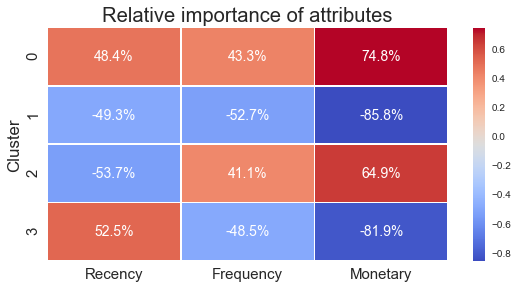

In [83]:
# Calculate average RFM values for each cluster
cluster_avg = df.groupby(['Cluster'])[rfm_columns].mean() 

# Calculate average RFM values for the total customer population
population_avg = df[rfm_columns].mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 4))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
ax = sns.heatmap(data=relative_imp, annot=True, cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": 1}, fmt=".1%")
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
plt.show()

* Using the plot above we can see which RFM characteristics influence on the cluster score

### RFM Cluster characteristics

* With an graphical analysis using the Snake plot and the importance heatmap we have the following profiling of clusters:
    * **Lowest**: High Recency and low Frequency and Monetary values (Non active and non money spenders)
    * **Medium**: Low Recency, Frequency, and Monetary values (Active but are not money spenders)
    * **High**: High Recency, Frequency, and Monetary Value (Non active but are money spenders)
    * **Highest**: Low Recency and high Frequency and Monetary values (Active and money spenders) 

In [84]:
# Assigning each cluster to its respective profile
df_rfm['Cluster'] = df_rfm['Cluster'].map({0: 'High', 2: 'Highest', 1: 'Medium', 3: 'Lowest'})

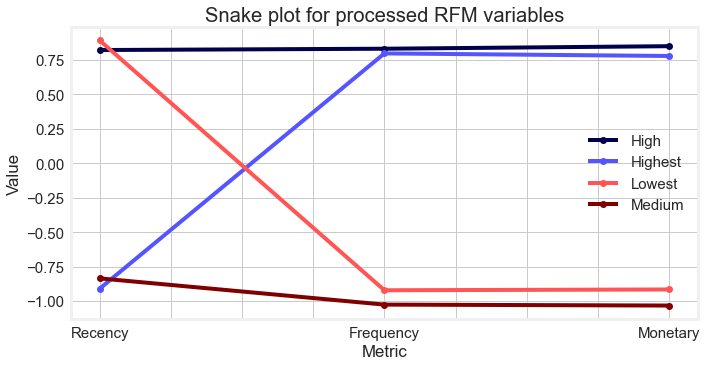

In [85]:
# Same plot but with renaming of clusters
# Melt the normalized dataset and reset the index
df_melt = pd.melt(
                df_rfm, 
# Assign ID and Cluster as ID variables                  
                id_vars=['ID', 'Cluster'],

# Assign RFMT values as value variables
                value_vars=['Recency', 'Frequency', 'Monetary'], 
# Name the variable and value
                var_name='Metric', value_name='Value'
                )

df_piv = df_melt.pivot_table("Value", "Metric", "Cluster")
df_piv = df_piv.reindex(['Recency', 'Frequency', 'Monetary'])
ax = df_piv.plot(marker="o", figsize=(10, 5), colormap='seismic')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Snake plot for processed RFM variables')
#plt.tight_layout()
plt.savefig('images/snakeplot_rfm.png', dpi=300, bbox_inches='tight')
plt.show()

In [86]:
# For reassigning purposes after mapping
df['Cluster'] = df_rfm['Cluster']

In [ ]:
# Assigning each cluster to its respective profile
#df['Cluster'] = df['Cluster'].map({0: 'High', 2: 'Highest', 1: 'Medium', 3: 'Lowest'})

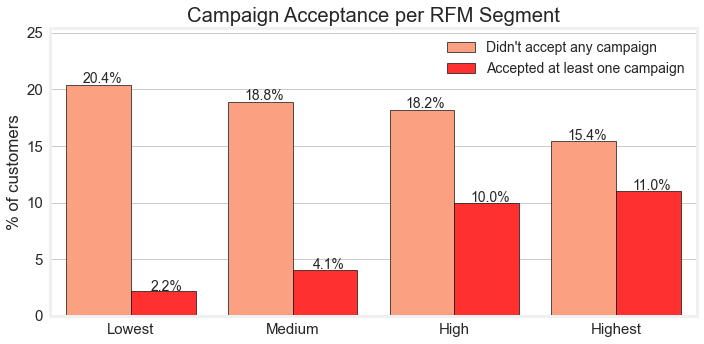

In [87]:
accpt_bar_plot(df, 'Cluster', title='Campaign Acceptance per RFM Segment')

* From the plot above we can notice that clusters that holds the customers with higher RFM values tend to accept more campaigns than those with low RFM scores.
* Knowing this we could use this simple segmentation to choose possible customers from clusters High, and Highest to contact.

## Using a simple RFM segmentation in order to increase ROI

In [88]:
campaign_success(df, 'All Customers')\
.append(campaign_success(df[df.Cluster.isin(['Highest', 'High'])], 'High and Highest RFM Segments'))\
.append(campaign_success(df[df.Cluster.isin(['Highest'])], 'Only the Highest RFM Segment'))

,Number of Customers,ROI,Success Rate
All Customers,2240,-0.45,0.15
High and Highest RFM Segments,1221,-0.26,0.20
Only the Highest RFM Segment,591,-0.03,0.27


### RFM approach key takeaways 

* Using the RFM segmentation proposed as we select better customers the ROI and Success Rates tend to increase, however the number of customers decreases, i.e, the reach of the campaign decreases.
* It could be a safer and simpler approach to reduce campaign costs.
* With better business insights the RFM segmentation can improve.

# Predictive Model - Binary Classification
* This section is deserved to show the improvements of using a classifier over the simple RFM approach

* Section Divided in:
    * Data Cleaning and Feature Engineering
    * Feature Selection
    * Model Selection
    * Model Evaluation

## Data Cleaning and Feature Engineering

* Income variable will be inputed as discussed before.
* Variables that have and absolute skewness value >.4 will be transformed using yeo-johnson transform
* Variables that weren't transformed will be scaled using StandardScaler
* Logistic vs SVM
* To prevent data leakage a data preprocessing will be constructed and ran separately in the training and test set.
* To also prevent any leaks in information variables such as AcceptedCmp will be removed. Also, new customers or other customers may not have these information.

In [89]:
# Checking for imbalanced dataset
df.Response.value_counts().to_frame('Response Count')

,Response Count
0,1906
1,334


### Imbalanced Dataset

* Only 15% (last campaign's success rate) of the data is labeled with 1.
* To overcome this problem the data will be split in a stratified manner, so that the training and test sets have the same percentage of classes occurrences.
* Also an oversampling technique called SMOTE will be used during training.

In [90]:
# Columns that will be used to train the classification model
data_columns = ['Education', 'Marital_Status', 'Income', 
           'Kidhome', 'Teenhome', 'MntWines', 'MntFruits',
           'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
           'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 
           'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
           'Complain', 'Age', 'Tenure', 'Recency', 'Cluster', 'Response', 'AgeGroup', ]

In [91]:
df_clean = df.set_index('ID')[data_columns].copy()

In [92]:
# Enconding RFM clusters, greater the cluster number better this client is in terms of RFM
df_clean['Cluster'] = df_clean['Cluster'].map({'Medium': 2, 'High': 3, 'Highest': 4, 'Lowest': 1})

In [93]:
# Preserving these columns
# They will be used for inputing NA values for the variable income
# Before training they will be dropped and replaced by the dummy variables
df_clean['raw_Education'] = df_clean['Education']
df_clean['raw_Marital_Status'] = df_clean['Marital_Status']

In [94]:
# One hot encoding of categorical values
df_clean = pd.get_dummies(df_clean, columns=['Education', 'Marital_Status'])

In [95]:
# Dropping redudant columns created because of get_dummies
# Could have been any of the columns for each categorical columns
df_clean = df_clean.drop(['Marital_Status_Other', 'Education_2n Cycle'], axis=1)

In [96]:
def process_data(df, target='Response', skew_threshold=.3):
    df_proc = df.copy()
    #['Education', 'Marital_Status', 'AgeGroup']
    # inputing income
    # Tries higher granular level and if fails uses population median
    df_proc.loc[:, 'Income'] = df_proc['Income'].fillna(df_proc.groupby(['raw_Education', 'raw_Marital_Status', 'AgeGroup'])\
                        ['Income'].transform('median')).fillna('median').isnull().sum()
    
    # Dropping columns used for inputting income NaN
    df_proc = df_proc.drop(['raw_Education', 'raw_Marital_Status', 'AgeGroup'], axis=1)
    
    # Finding columns to power transform using yeo-johnson
    # And finding columns that will be scaled using StandardScaler
    skew = df_proc[df_proc.columns.difference([target])].skew()
    pt_columns = skew[np.abs(skew) > skew_threshold].index
    scale_columns = skew[np.abs(skew) < skew_threshold].index
    
    df_proc[pt_columns] = PowerTransformer(method='yeo-johnson').fit_transform(df_proc[pt_columns])
    df_proc[scale_columns] = StandardScaler().fit_transform(df_proc[scale_columns])
    
    print(f'Mean Skew value of DF: {df_proc.skew().mean()}\nMedian Skew value of DF: {df_proc.skew().median()}')
    display(df_proc.agg(['mean', 'std']).round(4))
    
    
    return df_proc[df_proc.columns.difference([target])], df_proc[target]

In [97]:
# Stratified split, because of imbalanced data
# Splitting data before any scaling or sampling to avoid data leakage
df_train, df_test = train_test_split(df_clean, test_size=.3, stratify=df_clean.Response.values, random_state=42)

In [98]:
df_train.Response.value_counts()/df_train.shape[0]

0    0.850765
1    0.149235
Name: Response, dtype: float64

In [99]:
df_test.Response.value_counts()/df_test.shape[0]

0    0.85119
1    0.14881
Name: Response, dtype: float64

In [100]:
X_train, y_train = process_data(df_train)

Mean Skew value of DF: 1.1036888541391123
Median Skew value of DF: 0.02485581477197126


,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,Response,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
mean,0.0,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,...,0.1492,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000
std,0.0,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,...,0.3564,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003


## Feature Selection

* Variables will be selected using a recursive approach.
* RFECV with logistic regression.
* RFECV: recursive feature elimination and cross-validated selection of the best number of features.
* To prevent any leakage this will be done using the training set.
* This helps to prevent overfitting and reduces dimensionality resulting in less time fit our estimator.

In [101]:
rfe_selector = RFECV(estimator=LogisticRegression(solver='liblinear'), step=2, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
rfe_selector.fit(X_train, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:, rfe_support].columns.tolist()
print(f'Number of selected features: {len(rfe_feature)}')
rfe_feature

Number of selected features: 14


['Cluster',
 'Education_Basic',
 'Marital_Status_Married',
 'Marital_Status_Together',
 'MntFishProducts',
 'MntFruits',
 'MntMeatProducts',
 'MntWines',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebPurchases',
 'Recency',
 'Teenhome',
 'Tenure']

In [102]:
X_test, y_test = process_data(df_test)

Mean Skew value of DF: 1.165238557047795
Median Skew value of DF: 0.03604434275050207


,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,Response,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
mean,0.0,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,...,0.1488,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
std,0.0,1.0007,1.0007,1.0007,1.0007,1.0007,1.0007,1.0007,1.0007,1.0007,...,0.3562,1.0007,1.0007,1.0007,1.0007,1.0007,1.0007,1.0007,1.0007,1.0007


In [103]:
# Features that were selected
rfe_feature

['Cluster',
 'Education_Basic',
 'Marital_Status_Married',
 'Marital_Status_Together',
 'MntFishProducts',
 'MntFruits',
 'MntMeatProducts',
 'MntWines',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebPurchases',
 'Recency',
 'Teenhome',
 'Tenure']

In [104]:
# Using only the selected features using RFECV
X_test_slc = X_test[rfe_feature]
X_train_slc = X_train[rfe_feature]

## Model Selection

* The model chose was LogistRegression because of its simplicity and efficiency with binary classification tasks.
* Using GridSearch greedy framework to find the best parameters of the estimator, i.e, hyperparameter tuning.
* The training is done using StratifiedKFold to prevent overfitting.
* Every fold is oversampled using SMOTE so they have the same number of classes.

In [105]:
# Models and param grids to use on GridSearch
models = [{'name': 'logreg','label': 'Logistic Regression',
           'classifier': LogisticRegression(random_state=42),
           'grid': {"clf__C": np.logspace(-3,3,7), "clf__penalty": ["l1","l2"], "clf__solver": ['liblinear']}},]          
#           {'name': 'svm_rbf', 'label': 'SVC (RBF)',
#            'classifier': SVC(random_state=42),
#            'grid': {'clf__C': [1, 10, 100, 1000], 'clf__gamma': [0.001, 0.0001], 'clf__kernel': ['rbf']}}]

In [106]:
def model_selection(classifier, name, grid, X_train, y_train, X_test, y_test,
                    scoring, features_info='all_features', cv=StratifiedKFold(n_splits=5), n_jobs=-1):
    
    # Oversampling with smote
    smote = SMOTE(random_state=42)
    # Pipeline, every fold does as sampling
    pipeline = Pipeline([('sampling', smote), ('clf', classifier)])
    
    # GridSearch init
    gridsearch_cv=GridSearchCV(pipeline, 
                               grid,
                               cv=cv, 
                               scoring=scoring, 
                               n_jobs=n_jobs, 
                               verbose=1)
    
    gridsearch_cv.fit(X_train, y_train)
    
    # Creates the results dataframe
    results_dict = {}
    results_dict['classifier_name'] = name    
    results_dict['classifier'] = gridsearch_cv.best_estimator_
    results_dict['best_params'] = gridsearch_cv.best_params_
    results_dict['ROC_AUC_TRAIN'] = gridsearch_cv.best_score_
    results_dict['features_info'] = features_info
    
    # Compute the ROC_AUC score in the never seen test test
    y_pred = gridsearch_cv.best_estimator_.predict(X_test)
    results_dict['ROC_AUC_TEST'] = roc_auc_score(y_test, y_pred)
    
    return(results_dict)

results = []
for m in models:    
    results.append(model_selection(m['classifier'], 
                                   m['name'],
                                   m['grid'],
                                   X_train, 
                                   y_train,
                                   X_test,
                                   y_test,
                                   'roc_auc', 'all_features'))      
    
    results.append(model_selection(m['classifier'], 
                                   m['name'],
                                   m['grid'],
                                   X_train_slc, 
                                   y_train,
                                   X_test_slc,
                                   y_test,
                                   'roc_auc', 'selected_features'))   
    
results = pd.DataFrame.from_dict(results)
results

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished


,classifier_name,classifier,best_params,ROC_AUC_TRAIN,features_info,ROC_AUC_TEST
0,logreg,"(SMOTE(random_state=42), LogisticRegression(C=...","{'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__so...",0.847871,all_features,0.804231
1,logreg,"(SMOTE(random_state=42), LogisticRegression(C=...","{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__so...",0.852284,selected_features,0.806364


* With less and more relevant features we have almost the same score.

In [107]:
# Getting the best estimator
best = results.sort_values(by=['ROC_AUC_TEST', 'ROC_AUC_TRAIN'], ascending=False).head(1)
clf = best.iloc[0, 1]['clf']
display(clf)

LogisticRegression(C=0.1, random_state=42, solver='liblinear')

## Model Evaluation

In [108]:
# Predicting if a customer will accept or not the campaing
# This test has never been used
y_pred = clf.predict(X_test_slc)

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       572
           1       0.39      0.84      0.54       100

    accuracy                           0.78       672
   macro avg       0.68      0.81      0.70       672
weighted avg       0.88      0.78      0.81       672



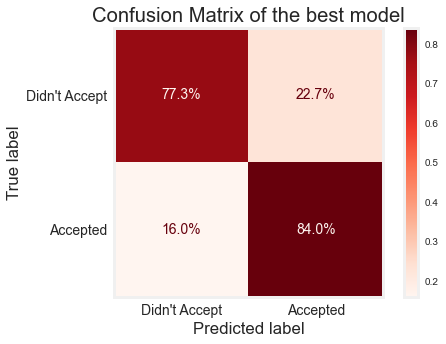

In [110]:
# Confusion matrix
f, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_confusion_matrix(clf, X_test_slc, y_test, normalize='true', display_labels=["Didn't Accept", 'Accepted'], cmap='Reds', ax=ax, values_format='.1%', )
ax.set_title('Confusion Matrix of the best model')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
plt.grid(None)
plt.tight_layout()
plt.savefig('images/cmatrix_model.png', dpi=300, bbox_inches='tight')
plt.show()

* Model performance:
    * The model does a good job of predicting customers who would accept the campaign.
    * Correctly predicted that 84% accepted the campaign and 77% did not.
    * This model is good enough for a pilot run over the current approach.

### Evaluating ROI and Success Rate for test set

In [111]:
# Assigning pred
X_test['accepted'] = y_pred

In [112]:
# original dataframe containing customers which the model said they would accept
df_model_accepted = df[df.ID.isin(X_test[X_test['accepted'] == 1].index)].copy()

In [113]:
campaign_success(df[df.ID.isin(df_test.index) & (df.Response == 1)], index='Perfect and Impossible Model').append(
    campaign_success(df[df.ID.isin(df_test.index)], index='All customers of the test set'))\
    .append(campaign_success(df_model_accepted, index='Customers selected by the model'))

,Number of Customers,ROI,Success Rate
Perfect and Impossible Model,100,2.67,1.00
All customers of the test set,672,-0.45,0.15
Customers selected by the model,214,0.44,0.39


* If we used this simple linear model on the test set we would increase our ROI in 89% and have a 39% campaign success rate.

## Feature Importance using SHAP

In [114]:
pd.set_option("display.max_columns",None)
shap.initjs()

In [115]:
explainer = shap.LinearExplainer(clf, X_train_slc)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [116]:
shap_values = explainer.shap_values(X_test_slc)

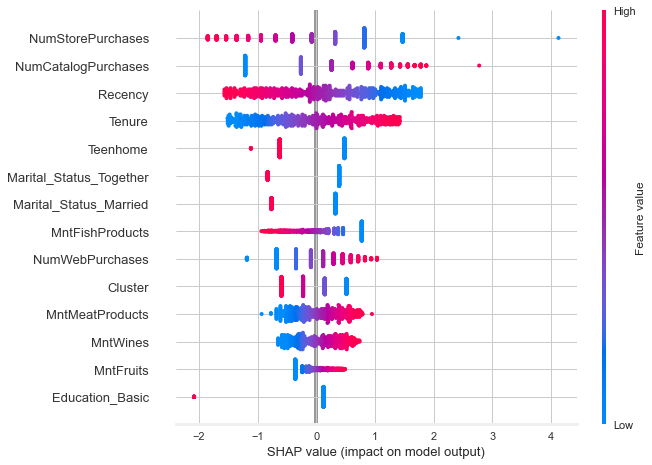

In [117]:
plt.figure()
shap.summary_plot(shap_values, X_test_slc)

* From the summary plot we have great insights on how the variables are affecting our model, for example:
    * Lower values o recency tend increase the chance predicting that a customer will accept the campaign
    * The longer the time as customer also increases the chances of predicting that it will accept
    * A relation on the number of catalog purchases and store purchases can be noticed, customers that have low purchases in store and high purchases in catalog may been more susceptible to campaigns.